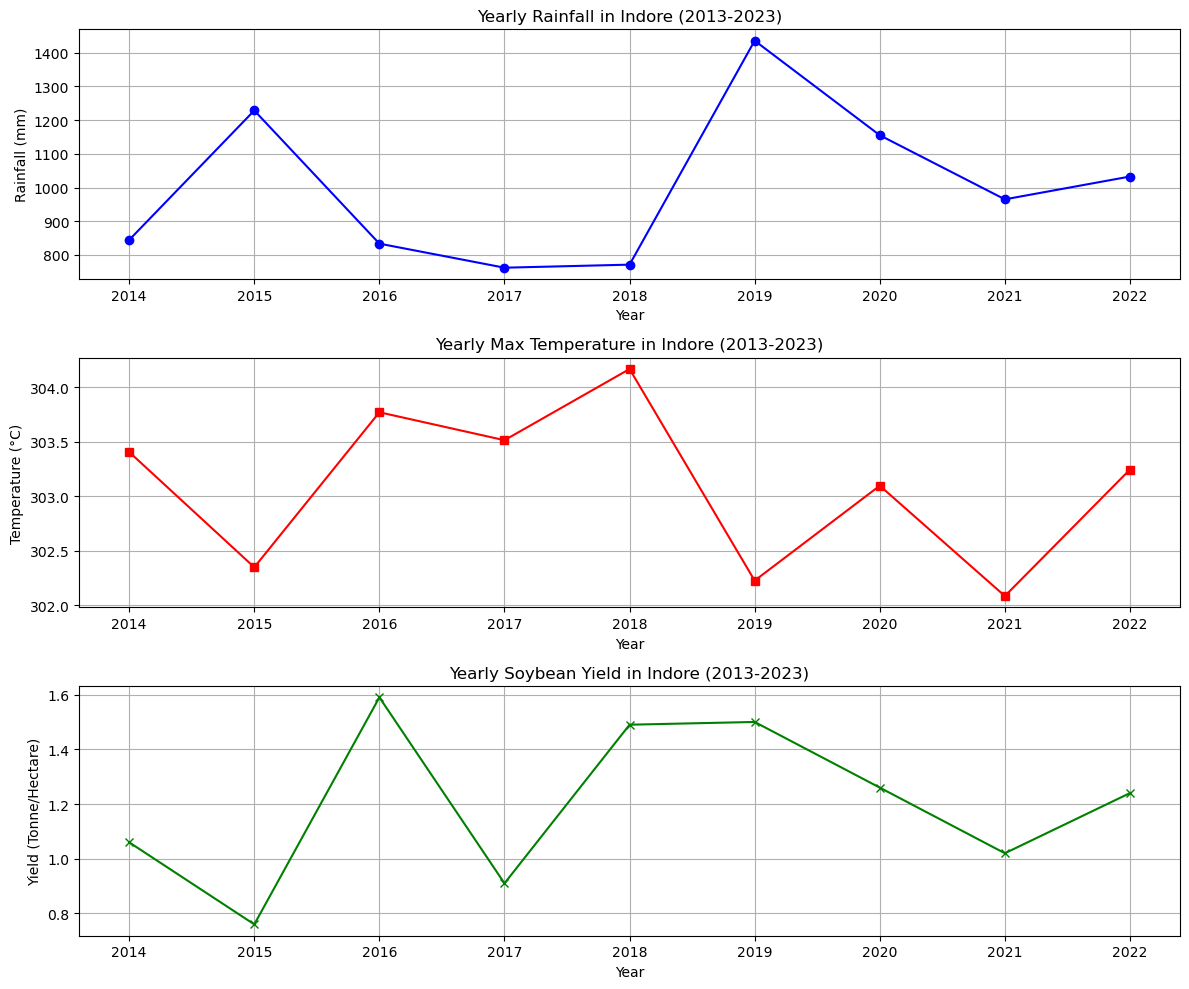

Correlation between Rainfall and Soybean Yield: 0.01, p-value: 0.975
Correlation between Temperature and Soybean Yield: 0.40, p-value: 0.289
Rainfall Model: Yield = 1.19 + 0.00 * Rainfall
Temperature Model: Yield = -46.40 + 0.16 * Temperature

Summary Statistics:
        Rainfall (mm)  Temperature (°C)  Yield (Tonne/Hectare)
count       9.000000          9.000000               9.000000
mean     1003.186360        303.094849               1.203333
std       231.517583          0.727550               0.287446
min       762.266968        302.083954               0.760000
25%       833.627576        302.347809               1.020000
50%       965.008272        303.244507               1.240000
75%      1155.112728        303.513550               1.490000
max      1435.534762        304.166687               1.590000


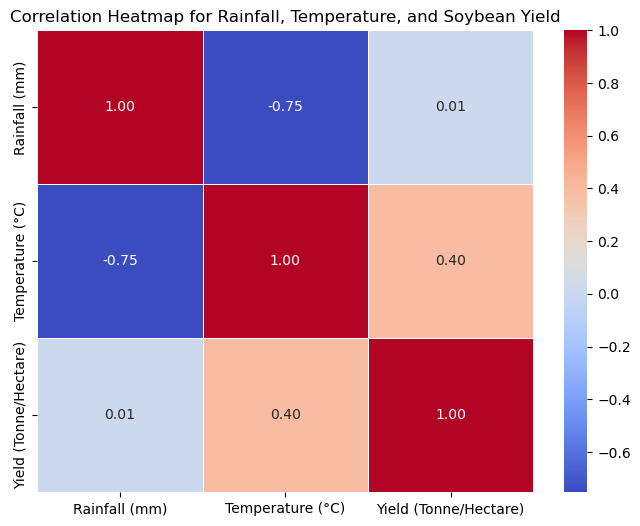

In [1]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# Soybean Yield Data
soybean_data = {
    "Year": [
        "2013-2014", "2014-2015", "2015-2016", "2016-2017", "2017-2018", 
        "2018-2019", "2019-2020", "2020-2021", "2021-2022", "2022-2023"
    ],
    "Area (Hectare)": [
        231222, 222000, 223000, 221000, 216900, 243606, 239086, 244059, 240418, 244719
    ],
    "Production (Tonnes)": [
        232841, 235000, 170000, 351000, 198460, 363217, 357912, 307514, 245707, 303696
    ],
    "Yield (Tonne/Hectare)": [
        1.01, 1.06, 0.76, 1.59, 0.91, 1.49, 1.5, 1.26, 1.02, 1.24
    ]
}

soybean_df = pd.DataFrame(soybean_data)
soybean_df['Year'] = soybean_df['Year'].apply(lambda x: int(x.split('-')[0]))

# Rainfall Data
data_dir = 'rainfall_data/'
indore_lat = 22.719568
indore_lon = 75.857727
rainfall_years = []

for year in range(2014, 2024):
    file_name = f'RF25_ind{year}_rfp25.nc'
    file_path = os.path.join(data_dir, file_name)
    
    if not os.path.exists(file_path):
        continue

    ds = xr.open_dataset(file_path)
    lat = ds['LATITUDE'].values
    lon = ds['LONGITUDE'].values
    lat_idx = np.abs(lat - indore_lat).argmin()
    lon_idx = np.abs(lon - indore_lon).argmin()
    rainfall_data = ds['RAINFALL'][:, lat_idx, lon_idx].values
    time_data = ds['TIME'].values
    
    rain_df = pd.DataFrame({'Date': time_data, 'Rainfall (mm)': rainfall_data})
    rain_df['Year'] = pd.to_datetime(rain_df['Date']).dt.year
    yearly_total = rain_df.groupby('Year')['Rainfall (mm)'].sum().reset_index()
    
    rainfall_years.append(yearly_total)

combined_rainfall = pd.concat(rainfall_years, ignore_index=True)

# Filter rainfall data to match years in soybean data
combined_rainfall = combined_rainfall[combined_rainfall['Year'].isin(soybean_df['Year'])]

# Temperature Data
temp_file_path = 'data_stream-oper_stepType-max.nc'
temp_file = nc.Dataset(temp_file_path, 'r')

temp_data = temp_file.variables['mx2t'][:]
lat_data = temp_file.variables['latitude'][:]
lon_data = temp_file.variables['longitude'][:]

lat_idx = np.abs(lat_data - indore_lat).argmin()
lon_idx = np.abs(lon_data - indore_lon).argmin()

indore_temp = temp_data[:, lat_idx, lon_idx]
time_data_temp = pd.to_datetime(temp_file.variables['valid_time'][:], unit='s').year

# Filter temperature data to match years in soybean data
indore_temp_yearly = pd.DataFrame({'Year': time_data_temp, 'Temperature (°C)': indore_temp})
indore_temp_yearly = indore_temp_yearly[indore_temp_yearly['Year'].isin(soybean_df['Year'])]
indore_temp_yearly = indore_temp_yearly.groupby('Year').mean().reset_index()

# Merge DataFrames
merged_df = pd.merge(combined_rainfall, soybean_df[['Year', 'Yield (Tonne/Hectare)']], on='Year')
merged_df = pd.merge(merged_df, indore_temp_yearly, on='Year')

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(merged_df['Year'], merged_df['Rainfall (mm)'], label='Rainfall (mm)', color='blue', marker='o')
plt.title('Yearly Rainfall in Indore (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(merged_df['Year'], merged_df['Temperature (°C)'], label='Temperature (°C)', color='red', marker='s')
plt.title('Yearly Max Temperature in Indore (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(merged_df['Year'], merged_df['Yield (Tonne/Hectare)'], label='Yield (Tonne/Hectare)', color='green', marker='x')
plt.title('Yearly Soybean Yield in Indore (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Yield (Tonne/Hectare)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Correlations
rain_yield_corr, rain_yield_pval = pearsonr(merged_df['Rainfall (mm)'], merged_df['Yield (Tonne/Hectare)'])
temp_yield_corr, temp_yield_pval = pearsonr(merged_df['Temperature (°C)'], merged_df['Yield (Tonne/Hectare)'])

# Linear Regression Models
X_rain = merged_df['Rainfall (mm)'].values.reshape(-1, 1)
y_yield = merged_df['Yield (Tonne/Hectare)'].values
rain_reg_model = LinearRegression().fit(X_rain, y_yield)

X_temp = merged_df['Temperature (°C)'].values.reshape(-1, 1)
temp_reg_model = LinearRegression().fit(X_temp, y_yield)

# Results
print(f"Correlation between Rainfall and Soybean Yield: {rain_yield_corr:.2f}, p-value: {rain_yield_pval:.3f}")
print(f"Correlation between Temperature and Soybean Yield: {temp_yield_corr:.2f}, p-value: {temp_yield_pval:.3f}")
print(f"Rainfall Model: Yield = {rain_reg_model.intercept_:.2f} + {rain_reg_model.coef_[0]:.2f} * Rainfall")
print(f"Temperature Model: Yield = {temp_reg_model.intercept_:.2f} + {temp_reg_model.coef_[0]:.2f} * Temperature")

summary_stats = merged_df[['Rainfall (mm)', 'Temperature (°C)', 'Yield (Tonne/Hectare)']].describe()
print("\nSummary Statistics:\n", summary_stats)

# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = merged_df[['Rainfall (mm)', 'Temperature (°C)', 'Yield (Tonne/Hectare)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap for Rainfall, Temperature, and Soybean Yield')
plt.show()